# Making Big Data Feel Small: Analysis of Hacker News Stories with BigQuery and Ibis (Part 1)

Ibis makes this process significantly less daunting by giving you all the tools you need to access your account with the code shown below. Not only that but it lets you analyse your data just like you would with pandas without needing to learn the bigquery specific dialect of sql. 

## Install and import the libraries we need

In this article we'll be looking at how to analyse millions of rows of data in seconds using Ibis and the bigquery backend. let's start by installing and importing the libraries we need to to access the Hacker News dataset from BigQuery. 


In [ ]:
#note that pyarrow is needed for ibis-biguery to build and does not currently support Python 3.11
#use python 10.0 instead. These are the only libraries you need to install for most of this tutorial 
!pip install --upgrade ibis-framework ibis-bigquery

In [8]:
#import ibis and filter out unimportant warnings 
import ibis
ibis.options.interactive = True


## Connect to BigQuery

In Ibis this only requires the commands below. We first connect to the database and then we connect to the specific table we want to query! In the past you would need to write out an SQL statement maybe something that looks 

In [ ]:
#connect to bq using your project_id and dataset_id (instructions in the blogpost this notebook accompanies on how to do this)
hnconn = ibis.bigquery.connect(
    project_id='your-project', 
    dataset_id='bigquery-public-data.hacker_news'
)

In [3]:
#this grabs the full HN table of stories and comments 
full = hnconn.table('full', database='bigquery-public-data.hacker_news')

## Preview the Dataset

Next we'll query the table just like we would a pandas dataframe, to get a better understanding of the data we have. 

In [4]:
full.head()

,title,url,text,dead,by,score,time,timestamp,type,id,parent,descendants,ranking,deleted
0,None,None,You&#x27;ve gotta be kidding. 99% of companies...,<NA>,jonas21,<NA>,1618596044,2021-04-16 18:00:44,comment,26837146,26832298,<NA>,<NA>,<NA>
1,None,None,"At least for tests like the SAT, this is not c...",<NA>,amznthrowaway5,<NA>,1618596038,2021-04-16 18:00:38,comment,26837145,26837020,<NA>,<NA>,<NA>
2,None,None,There were VERY early on the podcast revolutio...,<NA>,ProAm,<NA>,1618596033,2021-04-16 18:00:33,comment,26837143,26836880,<NA>,<NA>,<NA>
3,None,None,Art is not a commodity; there is no futures tr...,<NA>,heartbeats,<NA>,1618596032,2021-04-16 18:00:32,comment,26837142,26830117,<NA>,<NA>,<NA>
4,None,None,&gt;justify why this needs to exist\nwtf justi...,<NA>,yeetman21,<NA>,1618596029,2021-04-16 18:00:29,comment,26837141,26835956,<NA>,<NA>,<NA>


Lets have a look at how many of each type of submission are available in our dataset

In [5]:
full.type.value_counts()

,type,count
0,comment,28897394
1,story,4691514
2,pollopt,13843
3,job,15848
4,poll,2012


Next we'll check the time interval these HN stories and comments are from

In [6]:
full.info()

               Summary of bigquery-public-data.hacker_news.full               
                                33620611 rows                                 
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┓
┃ Name        ┃ Type                                    ┃  # Nulls ┃ % Nulls ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━┩
│ title       │ String(nullable=True)                   │ 29197896 │   86.85 │
│ url         │ String(nullable=True)                   │ 29470596 │   87.66 │
│ text        │ String(nullable=True)                   │  5191524 │   15.44 │
│ dead        │ Boolean(nullable=True)                  │ 32191451 │   95.75 │
│ by          │ String(nullable=True)                   │   995099 │    2.96 │
│ score       │ Int64(nullable=True)                    │ 29116587 │   86.60 │
│ time        │ Int64(nullable=True)                    │    26818 │    0.08 │
│ timestamp   │ Timestamp(timezone=None, nullable=Tr

In [6]:
#find what dates the data spans 
years = full.timestamp.year()
print(f'this table shows HN posts from {years.min()} to {years.max()}')

this table shows HN posts from 2006 to 2022


Finallly lets see how many rows and columns of data we will be working with

In [4]:
full.count()

33620611

In [5]:
len(full.columns)

14

We can see that we're working with over 33 Million rows of data! Using Ibis this shouldn't feel any different from working with Pandas on a smaller dataset though, it's also just as fast! 

## Clean the Data

Next we'll clean our data, by simply removing all of the comments that don't have text in them and all the stories that don't contain text or a title.

In [6]:
#filter the comments and print the number of comments 
full_comments = full.filter(full.type == 'comment')
print(f'Before cleaning we had {full_comments.count()} comments')

#clean the comments and print the number of comments after cleaning 
clean_comments = full_comments[full_comments['text'].notnull() | full_comments['title'].notnull()]
print(f'After cleaning we have {clean_comments.count()} comments')

Before cleaning we had 28897394 comments
After cleaning we have 28050701 comments


In [7]:
#filter the stories and print the number of stories
full_stories = full.filter(full.type == 'story')
print(f'Before cleaning we had {full_stories.count()} stories') 

#clean the stories and print the number of stories after cleaning 
clean_stories= full_stories[full_stories['title'].notnull()]
print(f'After cleaning we have {clean_stories.count()} stories')

Before cleaning we had 4691514 stories
After cleaning we have 4405643 stories


## Wrangling the Data

### Join the Comments and Story Data 

After removing the comments and stories that are not relevant we want to join the comments and story table so we can better analyse what the comments mean about the story. We'll carry out some sentiment analysis later on to figure out which kinds of articles got positive comments and which ones did not.

I'll use the inner join method in Ibis to join the clean stories and clean comments. I've matched the story id to the comment parent id as you can see below

In [8]:
#join comments and stories 
stories_and_comments = clean_stories.inner_join(clean_comments, predicates=clean_stories['id'] == clean_comments['parent'])

Next I'll choose only the columns I want to use which in this case are the story id, the story title, any text accompnying the title on HN, the comment text and the score the story got. 

In [9]:
#return subset of columns from the stories and comments table 
stry_and_cmnts = stories_and_comments[['id_x','title_x','text_x','text_y','score_x']]
stry_and_cmnts

,id_x,title_x,text_x,text_y,score_x
0,7502496,"Ask HN: Now that my site is live, how do I mak...","\tAs a newbie web programmer, I&#x27;ve been e...",I work for an ecommerce site and we generally ...,1
1,7502496,"Ask HN: Now that my site is live, how do I mak...","\tAs a newbie web programmer, I&#x27;ve been e...","Here are a few thoughts, some people may disag...",1
2,1171577,What is the mathematical expression of ascendi...,"If it is longer than f.sort(), then I'm not in...",Can you be more explicit about what you're ask...,1
3,1171577,What is the mathematical expression of ascendi...,"If it is longer than f.sort(), then I'm not in...",Mathematically you could express the concept o...,1
4,11187626,Can't digital signatures detect doctored video...,Major Operating systems should implement autom...,"<a href=""http:&#x2F;&#x2F;blog.elcomsoft.com&#...",1
...,...,...,...,...,...
9995,31715067,Lilium achieves first main wing transition for...,None,I love that tell-tales are still part of vesse...,442
9996,31715067,Lilium achieves first main wing transition for...,None,Why does this look like it&#x27;s entirely CGI?,442
9997,31715067,Lilium achieves first main wing transition for...,None,It&#x27;s always so fascinating to read about ...,442
9998,31715067,Lilium achieves first main wing transition for...,None,I don’t care how skeptical or how much of a do...,442


Lets now run a groupby and to find how many comments each story has.

In [10]:
#show all stories, sorted by number of comments 
num_comments = stry_and_cmnts.text_y.count()
stories_grouped = stry_and_cmnts.group_by('title_x').aggregate(comments=num_comments).sort_by(ibis.desc(num_comments))

stories_grouped 

,title_x,comments
0,Ask HN: What are you working on?,1702
1,Please tell us what features you'd like in new...,1288
2,Ask HN: What's your quarantine side project?,1091
3,Ask HN: Share your personal site,1020
4,Ask HN: Who is hiring? (May 2018),995
...,...,...
9995,Apple Developer Website Update,51
9996,Oracle Giving Away 4-Core 24 GB Memory Ampere ...,51
9997,Generating More of My Favorite Aphex Twin Track,51
9998,AT&T to Acquire T-Mobile USA for $39 Billion,51


I'm also a bit curious about how many stories we're dealing with here, so lets find that too

In [ ]:
stories_grouped_numbers = stories_grouped.aggregate(comments=num_comments)
stories_grouped_numbers.count()

1106312

Great it looks like we're working with over 1milion stories! 

## Analysing the data

Next lets have a closer look at some things the data tells us. 
We'll start by finding out what score a story has to have to be considered good, average and not so good. 

The lowest score a story could have is 

In [191]:
min_score = stry_and_cmnts.score_x.min()
min_score

-1

The highest score a story so far has attained

In [192]:
max_score = stry_and_cmnts.score_x.max()
max_score

6015

For a story to be considered average it should have a score of about 185 like we can see below

In [193]:
avg_score= stry_and_cmnts.score_x.mean()
avg_score

185.62919906694896


## What Are People Writing About On HN? 

To help us begin to understand which stories are the most popular on HN, let's take the titles and arrange them in decending order based on their score.

In [16]:
titles = stry_and_cmnts[['id_x','title_x', 'score_x']].distinct()
sorted_titles = titles.sort_by(ibis.desc('score_x'))
sorted_titles

,id_x,title_x,score_x
0,16582136,Stephen Hawking has died,6015
1,11116274,A Message to Our Customers,5771
2,3078128,Steve Jobs has passed away.,4338
3,31261533,Mechanical Watch,4298
4,24872911,YouTube-dl has received a DMCA takedown from RIAA,4240
...,...,...,...
9995,9657271,Tmux has left SourceForge,504
9996,16738016,UN: Facebook has turned into a beast in Myanmar,504
9997,25159097,PostgREST: REST API for any Postgres database,504
9998,8424696,Adobe Spyware Reveals Again the Price of DRM: ...,504


The top story is about the passing away for Stephan Hawks. I'd like to see a little more context about the second story so lets pull it's details from the full `stry_and_cmnts` table we made above to check if we learn more.

In [25]:
stry_popular = stry_and_cmnts[stry_and_cmnts.id_x == 11116274]
stry_popular

,id_x,title_x,text_x,text_y,score_x
0,11116274,A Message to Our Customers,None,I am happy AAPL is taking this stance. But I c...,5771
1,11116274,A Message to Our Customers,None,"Dear Tim Cook,<p>Thank you!",5771
2,11116274,A Message to Our Customers,None,"&quot;In the wrong hands, this software — whic...",5771
3,11116274,A Message to Our Customers,None,If the UK record on anti-terror scope creep is...,5771
4,11116274,A Message to Our Customers,None,So the FBI is asking Apple to build a tool tha...,5771
...,...,...,...,...,...
208,11116274,A Message to Our Customers,None,I think there are two orthogonal questions:<p>...,5771
209,11116274,A Message to Our Customers,None,A phone without a backdoor would be illegal in...,5771
210,11116274,A Message to Our Customers,None,"The numerical passcode is likely his ATM pin, ...",5771
211,11116274,A Message to Our Customers,None,<p><pre><code> While we believe the FBI’s int...,5771


Unfortunatley there is no story text uploaded to HN for this article. However, there are a bunch of comments and we can see that they all have something to do with Apple! Looks like something to so with FBI and passcodes etc. Interesting!!!
  
  
It would also be nice to know which topics or words appear the most on HN.

One way to figure this out is to use the natural language processing module from spacy to parse out the most defining word from each title. I'll need to use a function I create on my own (a User Defined Function) that takes each title from the 'title_x' column and returns the main entity of the sentence. Here's what the function looks like

In [26]:
def find_entity(title):
    parsed_title = nlp(title)
    entity_arr = []
    for num, entity in enumerate(parsed_title.ents):
        entity_arr.append(entity.text)
    return  ' '.join(entity_arr)

Unfortunatley Ibis does not provide full support for UDF's yet but to get around this, we can call execute on the sorted titles column to return a pandas dataframe. We can then use the apply function to use our UDF on the returned pandas dataframe. 

Here's what I mean. Since Ibis uses lazy evaluation, `sorted_titles["title_x"]` is an ibis expression that isn't actulally pulling any data into memory. This is very effient and it's for the most part what's been happening before this point. 

In [27]:
type(sorted_titles["title_x"])

ibis.expr.types.strings.StringColumn

However if I call the execute method, Ibis will pull the data in the column into memory and give us a pandas dataframe to work with. This isn't quite as efficient, but allows us to apply our UDF and we can always switch right back to an Ibis table once we're done! 

In [28]:
new_table = sorted_titles["title_x"].execute()

#this is a pandas dataframe
type(new_table)

pandas.core.series.Series

Lets run the `find_entity` function we had above 

In [45]:
entity_col = new_table.apply(find_entity)

Lets get the value count of each entity and plot this out. We'll also limit the results the the top 24 entities. 

In [46]:
top_entities = entity_col.value_counts()
top_entities = top_entities[1:25:]

Lets preview this table 

In [47]:
top_entities

Google         138
Apple           49
Amazon          44
GitHub          34
YouTube         31
Facebook        28
2018            25
Twitter         22
US              22
Microsoft       22
one             19
2017            19
2016            19
JavaScript      17
2020            17
EU              16
U.S.            16
CSS             16
2014            14
Android         14
Hacker News     13
One             12
Chrome          12
2               11
Name: title_x, dtype: int64

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import spacy
nlp = spacy.load("en_core_web_sm")

Great! Now lets polt the graph to find the words or phrases that appear the most. 

Text(0, 0.5, 'counts')

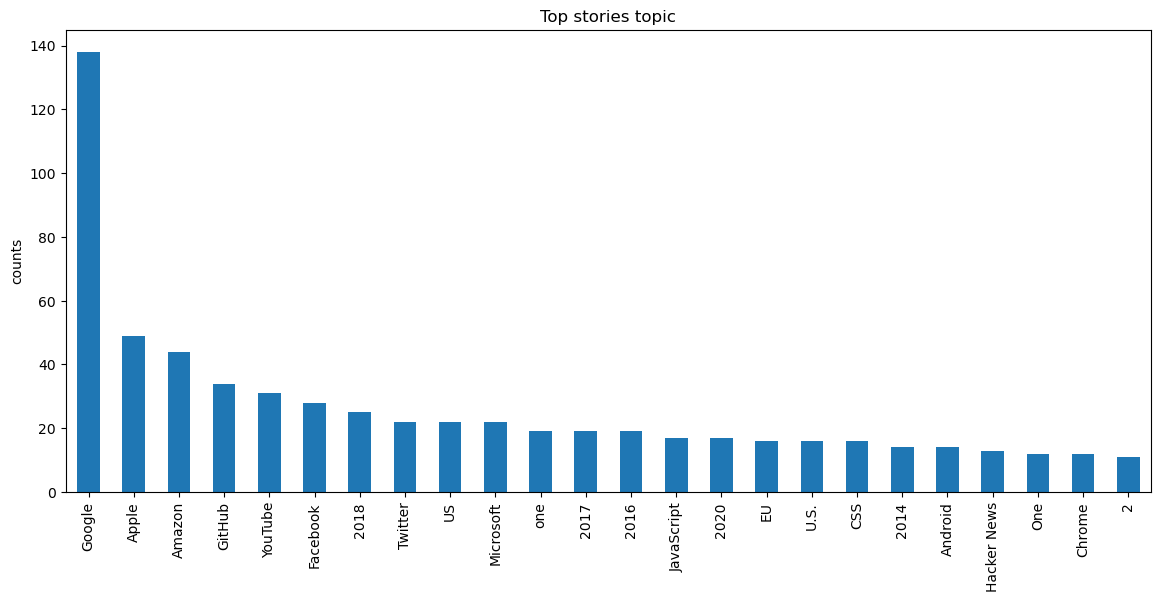

In [48]:
top_entities.plot(x="entity",y=["counts"],
                     kind="bar",figsize=(14,6),
                     title='Top stories topic').set_ylabel("counts")

This is very helpful! I'll make a cute word cloud as well to visulise this even more

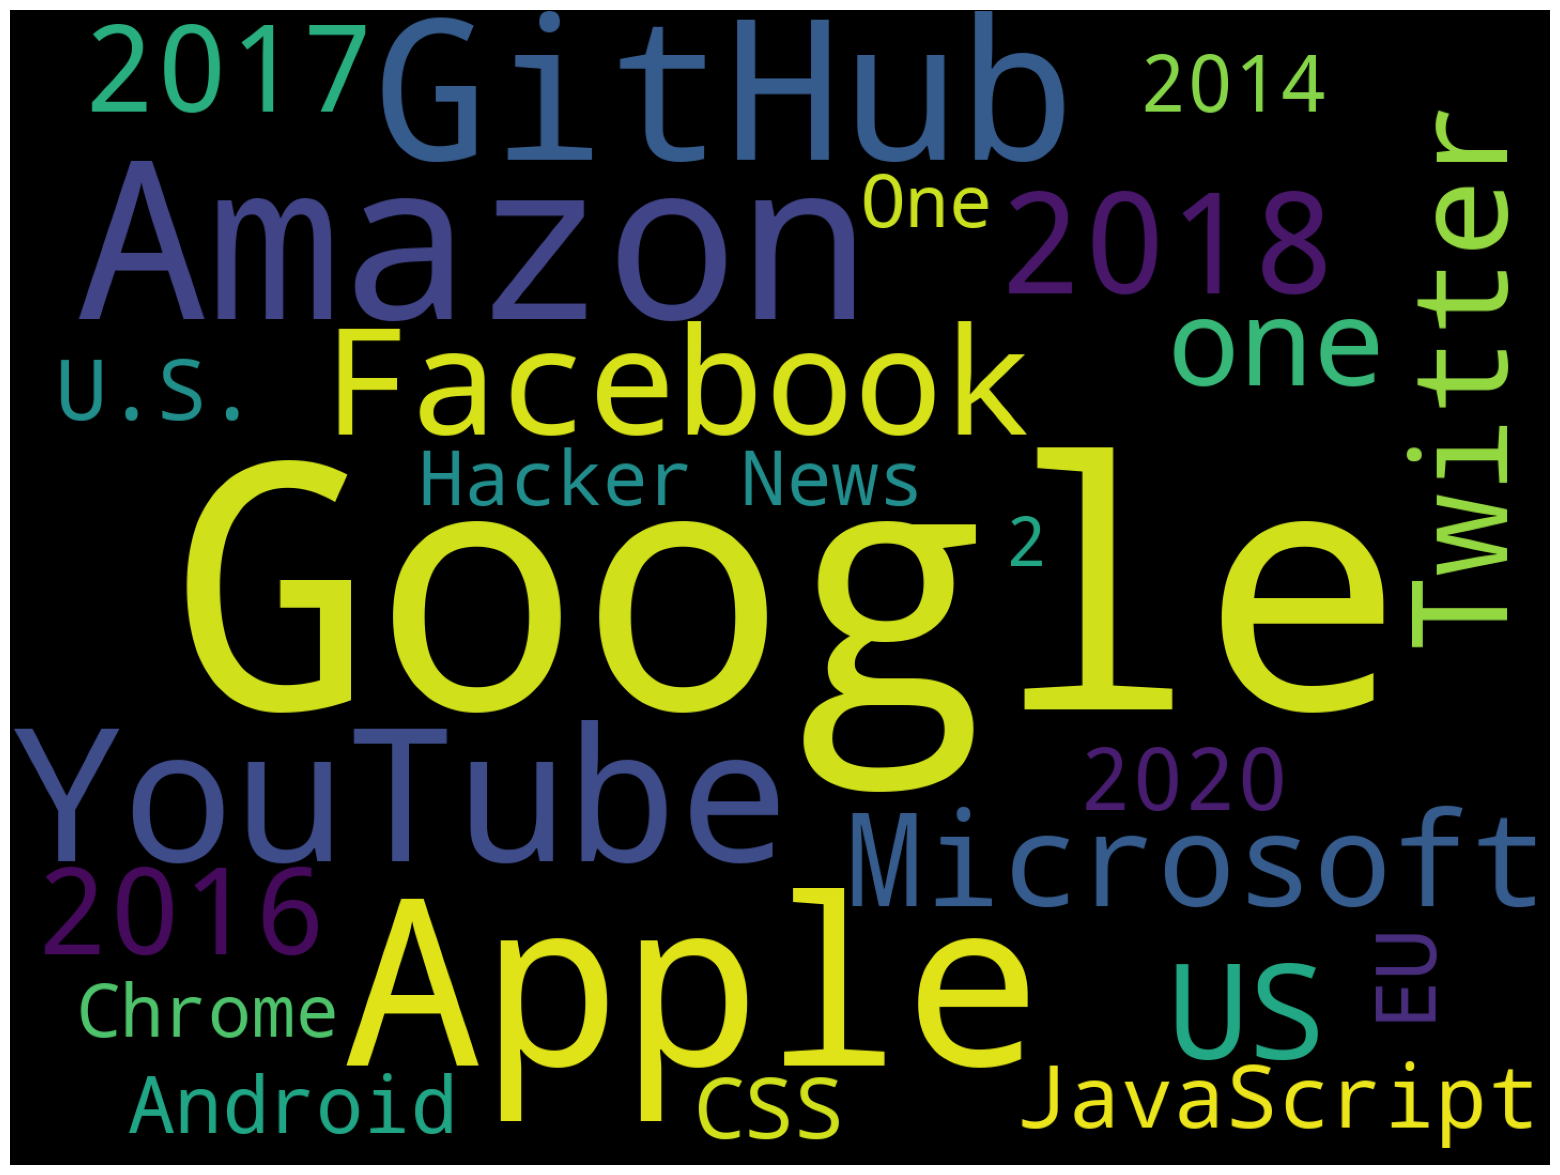

In [49]:
cloud = WordCloud(width=1440, height= 1080,max_words= 200).generate_from_frequencies(top_entities)
plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off');
plt.show()

Google is by far the most mentioned entity followed by Apple, Amazon and Github, with YouTube and Facebook not far behind. This seems to corroborate what we know about FAANG (Facebook, Apple, Amazon, Netflix and Google) being some of the most popular companies in tech, though Nteflix doesn't seem to appear on the list. 

Something to potentially do here is to try this out with other NLP libaries in case the results end up being different. 

Lets take the`top_entities` pandas table and turn it back into an ibis table here's how I'd do it. 

In [50]:
top_entities = ibis.memtable(top_entities)

Let's make sure that worked

In [51]:
type(top_entities)

ibis.expr.types.relations.Table

Next I'd like to run some sentiment analysis on our HN dataset to figure out what sorts of posts have negative comnments and which one's tend to get good one's. Since this post is already long, I'll share the steps for this is a Part 2 blog post that you can expect to go live in the next few days. 